**Data cleaning and exploratory data analysis.**

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
%matplotlib inline
from collections import Counter
import numpy as np
pd.set_option('display.max_columns', None)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/fake_job_postings.csv')

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64


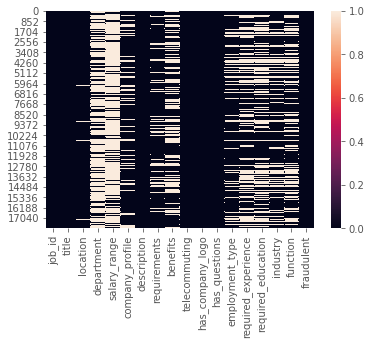

In [0]:
print(df.isna().sum())
sns.heatmap(df.isnull())

Heatmap shows data has many null values. So it needs tobe cleaned first.

In [0]:
print(df.shape)

(17880, 18)


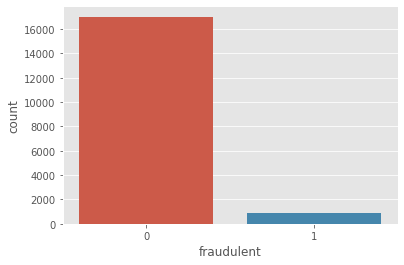

In [0]:
plt.figure(1)
sns.countplot( x= df['fraudulent'], data= df)

Also in the main data only 6 percent values are fraudelent. 

In [0]:
df2 = df.copy()
df2.drop(['salary_range', 'job_id', 'department', 'benefits'], axis = 1, inplace = True)
df2 = df2.sort_values('title').reset_index(drop = True)
df2.isna().sum()

title                     0
location                346
company_profile        3308
description               1
requirements           2695
telecommuting             0
has_company_logo          0
has_questions             0
employment_type        3471
required_experience    7050
required_education     8105
industry               4903
function               6455
fraudulent                0
dtype: int64

Some features are dropped

---
salary range = It has many null values. So it will make much difference if fill it by bfill, ffill or by average.

---
Job id = This is not useful in prediction.

---
department = So many null spaces.

---
Benefits = It can be covered in other features. 

---








In [0]:
df2['employment_type'] = df2['employment_type'].bfill(axis=0)
df2['required_experience'] = df2['required_experience'].bfill(axis=0)
df2['required_education'] = df2['required_education'].bfill(axis = 0)
df2['industry'] = df2['industry'].bfill(axis=0)
df2['function'] = df2['function'].bfill(axis=0)

Features like these can be back filled because many of them have less no of categories. And even if there occurs a mismatch due to bfill it will be in less proportion and will not affect the prediction.

In [0]:
df3 = df2.copy()

In [0]:
df3 = df3[df3['description'].notna()]

In [0]:
print(df3.isna().sum())
print(df3.shape)

title                     0
location                346
company_profile        3307
description               0
requirements           2694
telecommuting             0
has_company_logo          0
has_questions             0
employment_type           2
required_experience       2
required_education        2
industry                  2
function                  2
fraudulent                0
dtype: int64
(17879, 14)


In [0]:
df3 = df3.dropna(axis = 0, how = 'any')
df3.isna().sum()

title                  0
location               0
company_profile        0
description            0
requirements           0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

And with remaining features those we couldnt fill, their respective rows are simply dropped from data.

In [0]:
df3.shape

(12501, 14)

In [0]:
df3 = df3.drop_duplicates(keep = 'first')

In [0]:
df4 = df3.copy()

In [0]:
df4.shape

(12264, 14)

In [0]:
df4['description'] = df4['description'] + ' ' + df4['requirements'] + ' ' + df4['company_profile']
df4.drop(['company_profile', 'requirements'], axis = 1, inplace = True)

After this, for the ease of NLP, features which have sentences and paragraphs are concatenated to a one single feature. 

In [0]:
df4['country_code'] = df4['location'].str.split(',', expand=True)[0]
df4['city'] = df4['location'].str.split(',', expand = True)[2]

Country and city are separated from location.

In [0]:
df4.loc[df4['city'] == ' ', 'city'] = np.nan

In [0]:
df4.isnull().sum()

title                    0
location                 0
description              0
telecommuting            0
has_company_logo         0
has_questions            0
employment_type          0
required_experience      0
required_education       0
industry                 0
function                 0
fraudulent               0
country_code             0
city                   992
dtype: int64

In [0]:
df4.dropna(inplace = True)

In [0]:
pip install pycountry

     |████████████████████████████████| 10.0MB 2.6MB/s 
  Created wheel for pycountry: filename=pycountry-19.8.18-py2.py3-none-any.whl size=10627361 sha256=7acbb87b7cc0283f1afcbff9334ed960b67f4206ea9452ee73896b64901ed412
  Stored in directory: /root/.cache/pip/wheels/a2/98/bf/f0fa1c6bf8cf2cbdb750d583f84be51c2cd8272460b8b36bd3
Successfully built pycountry


In [0]:
import pycountry
list_alpha_2 = [i.alpha_2 for i in list(pycountry.countries)]
def country(df):
    if df['country_code'] in list_alpha_2:
        return pycountry.countries.get(alpha_2 = df['country_code']).name
df4['country_name'] = df4.apply(country, axis = 1)

In [0]:
df4.drop(['location', 'country_code'], axis = 1, inplace = True)

In [0]:
df4.head()

,title,description,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,city,country_name
2,Piping Material Engineer,Corporate overviewAker Solutions is a global p...,0,1,0,Full-time,Mid-Senior level,Master's Degree,Oil & Energy,Engineering,1,Houston,United States
3,"Discipline Manager Civil, Structural, Marine...",Corporate overviewAker Solutions is a global p...,0,1,0,Full-time,Entry level,Professional,Oil & Energy,Engineering,1,Houston,United States
4,FEA Senior engineer,Corporate overviewAker Solutions is a global p...,0,1,0,Full-time,Entry level,Master's Degree,Oil & Energy,Engineering,1,Houston,United States
9,AUTOCAD OPERATOR,Responsibilities:Using a project database syst...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Staffing and Recruiting,Engineering,0,Cebu,Philippines
13,Accounting Clerk,"Job DescriptionVerify, obtain approvals and pa...",0,1,1,Full-time,Associate,High School or equivalent,Accounting,Customer Service,1,AUSTIN,United States


In [0]:
df4.shape

(11272, 13)

In [0]:
df_clean = df4.copy()

In [0]:
df_clean.head()
df_clean.to_csv('Clean_data1.csv')

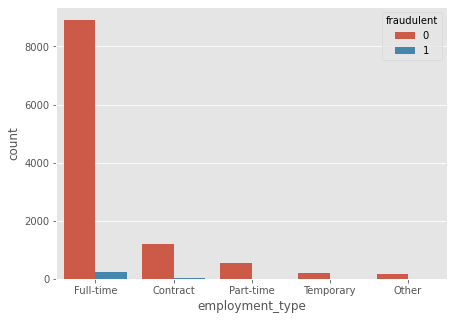

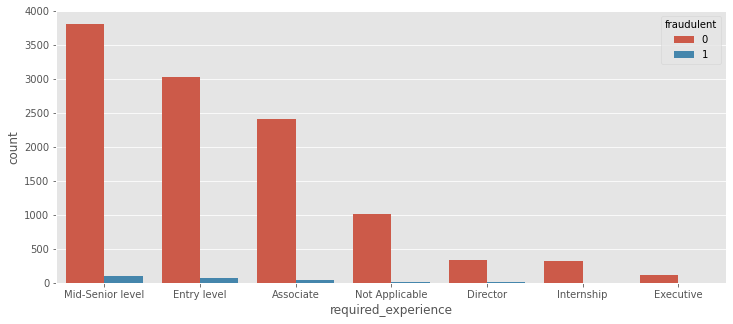

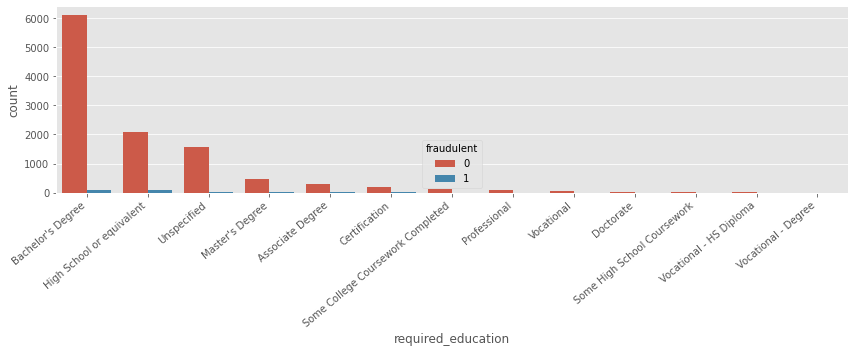

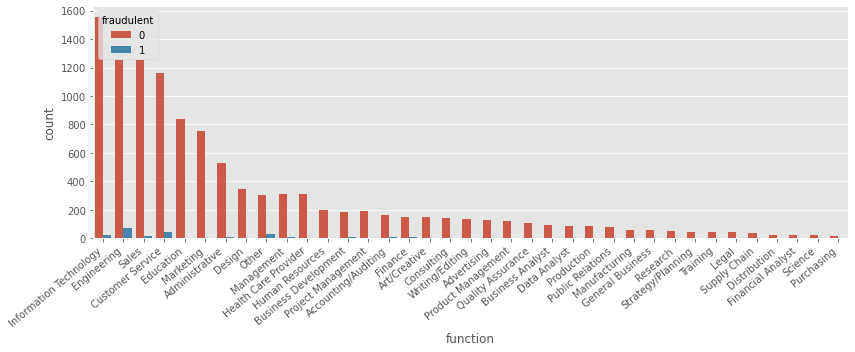

In [0]:
plt.figure(figsize = (7, 5))
sns.countplot( x= 'employment_type' ,hue = 'fraudulent', data= df_clean, order = df_clean['employment_type'].value_counts().index)
plt.figure(figsize = (12, 5))
sns.countplot( x= 'required_experience' ,hue = 'fraudulent', data= df_clean, order = df_clean['required_experience'].value_counts().index)
plt.figure(figsize = (12, 5))
ax = sns.countplot( x= 'required_education' ,hue = 'fraudulent', data= df_clean, order = df_clean['required_education'].value_counts().index )
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.figure(figsize = (12, 5))
axa = sns.countplot( x= 'function' ,hue = 'fraudulent', data= df_clean, order = df_clean['function'].value_counts().index )
axa.set_xticklabels(axa.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()


**Natural Language Processing**\
\
From here starts a natutral language processing (NLP) part. It needs some libraries to download everytime when runtime is started.

In [0]:
import nltk
nltk.download('popular')

In [0]:
import spacy.cli
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [0]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
import string
import base64
import re
from collections import Counter
import spacy
spacy.load('en_core_web_sm')
nlp = spacy.load('en_core_web_lg')
punctuations = string.punctuation
from spacy.lang.en import English
parser = English()

In [0]:
df_clean['fraudulent'].value_counts()

0    11023
1      249
Name: fraudulent, dtype: int64

In [0]:
def cleanup(docs, logging = False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 100 == 0 and logging:
            print ("Processed %d out of %d documents."%(counter, len(docs)))
        counter +=1
        doc = nlp(doc, disable = ['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stop_words and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

This function is used for cleaning the feature named description. By using this, common words (Stopwords), pronouns and syambols are removed. So only words which are affecting the prediction can be used.

In [0]:
Fraud_1 = [text for text in df_clean[df_clean['fraudulent'] == 1]['description']]
Fraud_0 = [te for te in df_clean[df_clean['fraudulent'] == 0]['description']]

In [0]:
Fraud_1_clean = cleanup(Fraud_1)
Fraud_1_clean = ' '.join(Fraud_1_clean).split()


In [0]:
Fraud_0_clean = cleanup(Fraud_0)
Fraud_0_clean = ' '.join(Fraud_0_clean).split()

In [0]:
print(len(Fraud_1_clean))
print(len(Fraud_0_clean))

64441
2770033


In [0]:
Fraud_1_common_words = [word[0] for word in Counter(Fraud_1_clean).most_common(20)]
Fraud_1_common_counts = [word[1] for word in Counter(Fraud_1_clean).most_common(20)]

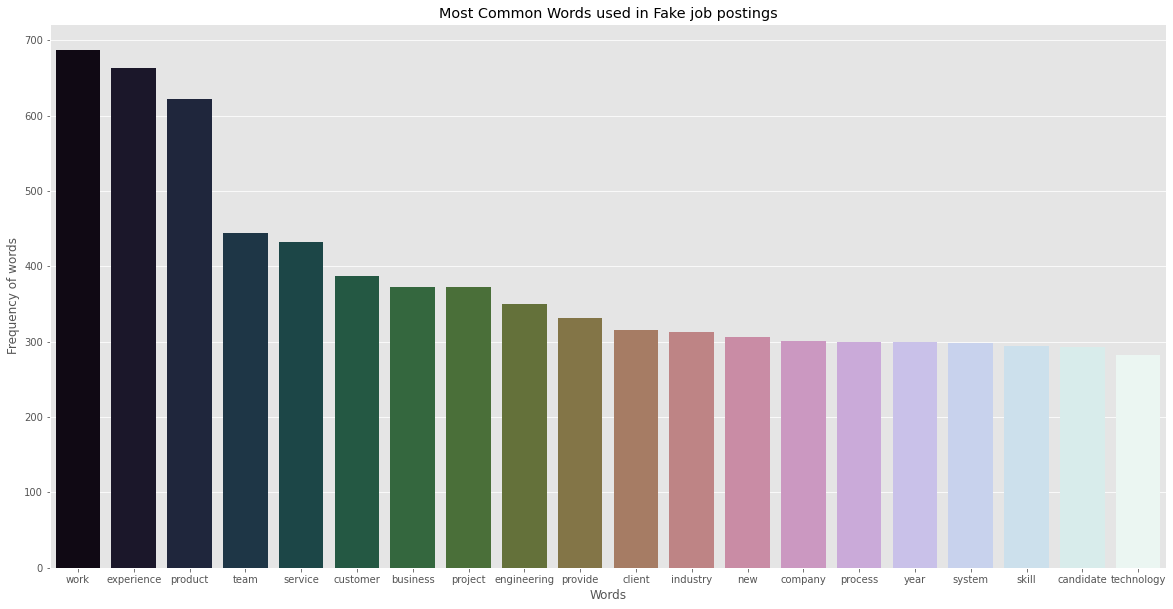

In [0]:
fig = plt.figure(figsize = (20, 10))
pal = sns.color_palette("cubehelix", 20)
sns.barplot(x = Fraud_1_common_words, y = Fraud_1_common_counts, palette=pal)
plt.title('Most Common Words used in Fake job postings')
plt.ylabel("Frequency of words")
plt.xlabel("Words")
plt.show()

In [0]:
Fraud_0_common_words = [word[0] for word in Counter(Fraud_0_clean).most_common(20)]
Fraud_0_common_counts = [word[1] for word in Counter(Fraud_0_clean).most_common(20)]

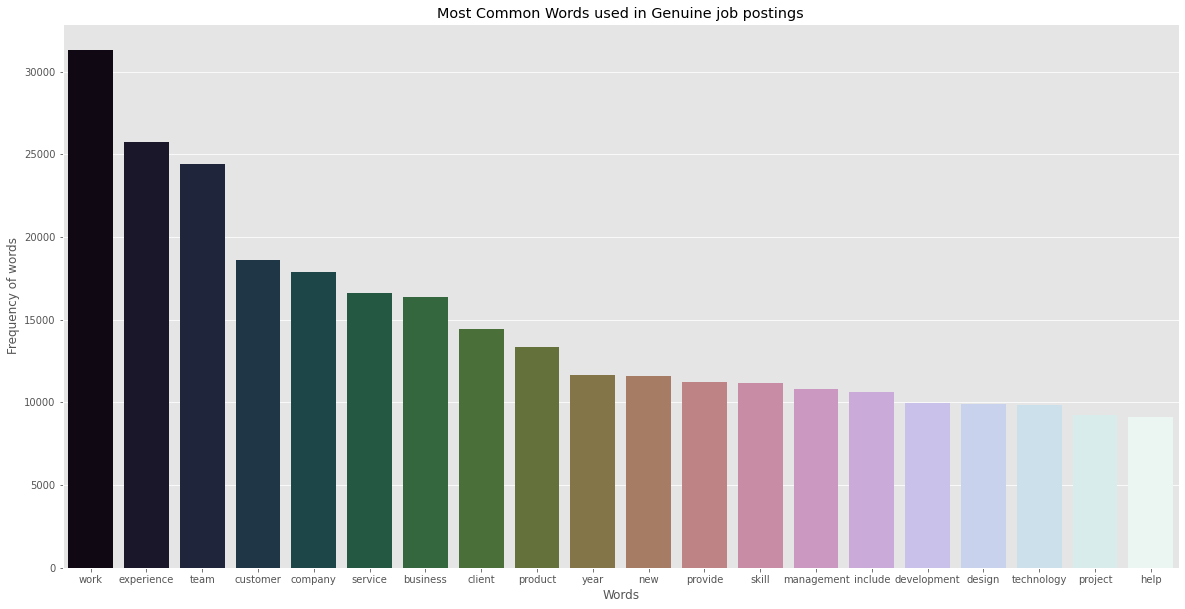

In [0]:
fig = plt.figure(figsize = (20, 10))
pal = sns.color_palette("cubehelix", 20)
sns.barplot(x = Fraud_0_common_words, y = Fraud_0_common_counts, palette=pal)
plt.title('Most Common Words used in Genuine job postings')
plt.ylabel("Frequency of words")
plt.xlabel("Words")
plt.show()

The above graphs shows the words which are mostly occured in fake vs true job post.